# 02 (Cont'd)

## 02.01 Importing modules and styles

In [1]:
import pandas as pd #used
import numpy as np #used
import pickle
import os
import seaborn as sns
import random
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

C:\Users\paolo\anaconda3\envs\exts-aml2\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Activate Seaborn default style
sns.set()

# Get a few colors from the default color palette
blue, green, red = sns.color_palette()[:3]

## 02.02 Importing data

In [3]:
# Load train data
with np.load(os.path.join('data', 'cifar4-train.npz'), allow_pickle=False) as npz_file:
    cifar_tr = dict(npz_file.items())
with np.load(os.path.join('data', 'cifar4-test.npz'), allow_pickle=False) as npz_file:
    cifar_te = dict(npz_file.items())
X_cifar_pixels_tr=cifar_tr['pixels']
X_cifar_overfeat_tr=cifar_tr['overfeat']
y_cifar_tr=cifar_tr['labels']
X_cifar_pixels_te=cifar_te['pixels']
X_cifar_overfeat_te=cifar_te['overfeat']

## 02.03 Splitting data

In [4]:
# Creating a test set
ssplit = StratifiedShuffleSplit(n_splits=500, test_size=1000, random_state=0)

for train_index, test_index in ssplit.split(X_cifar_pixels_tr, y_cifar_tr):
    X_pixels_tr, X_pixels_te = X_cifar_pixels_tr[train_index], X_cifar_pixels_tr[test_index]
    X_overfeat_tr, X_overfeat_te = X_cifar_overfeat_tr[train_index], X_cifar_overfeat_tr[test_index]
    y_tr, y_te = y_cifar_tr[train_index], y_cifar_tr[test_index]

In [5]:
# Verifying shapes
print('Train sets shapes')
print('Pixels:',X_pixels_tr.shape)
print('Overfeat features:',X_overfeat_tr.shape)
print('Labels:',y_tr.shape)
print()
print('Test sets shapes')
print('Pixels:',X_pixels_te.shape)
print('Overfeat features:',X_overfeat_te.shape)
print('Labels:',y_te.shape)

Train sets shapes
Pixels: (4000, 3072)
Overfeat features: (4000, 4096)
Labels: (4000,)

Test sets shapes
Pixels: (1000, 3072)
Overfeat features: (1000, 4096)
Labels: (1000,)


## 02.04 PCA preprocessing

We will use a PCA of 175 components explaining 90% of the variance which dramatically reduces the size of the input data an thus the processing times.

In [6]:
# Reducing the Overfeat features with the PCA using 175 components
scaler=StandardScaler()
X_Of_tr_r=scaler.fit_transform(X_overfeat_tr) #standardising features
pca175=PCA(n_components=175)
X_Of_tr_175r=pca175.fit_transform(X_Of_tr_r)
pve = pca175.explained_variance_ratio_ # Variance explained by components
print('Shape of preprocessed Overfeat matrix:',X_Of_tr_175r.shape)
print('Percentage of variance explained: {:.2f}'.format(np.max(np.cumsum(pve))))

Shape of preprocessed Overfeat matrix: (4000, 175)
Percentage of variance explained: 0.90


## 02.05 Splitting reduced data

In [7]:
# Creating a test set
ssplit = StratifiedShuffleSplit(n_splits=500, test_size=800, random_state=0)

for train_index, valid_index in ssplit.split(X_Of_tr_175r, y_tr):
    X_train, X_valid = X_Of_tr_175r[train_index], X_Of_tr_175r[valid_index]
    y_train, y_valid = y_tr[train_index], y_tr[valid_index]

In [8]:
# Verifying shapes
print('Reduced train features:',X_train.shape)
print('Train Labels:',y_train.shape)
print()
print('Reduced validation features:',X_valid.shape)
print('Labels:',y_valid.shape)

Reduced train features: (3200, 175)
Train Labels: (3200,)

Reduced validation features: (800, 175)
Labels: (800,)


# 03. Decision trees and random forests

## 03.01 Decision tree, grid search

In [9]:
# Depth range
depths=np.arange(2,22) #setting depth values for grid searching

train_scores=[]
valid_scores=[]

for depth_n in depths:
    #on train
    dt=DecisionTreeClassifier(criterion='gini',max_depth=depth_n,random_state=0)
    dt.fit(X_train,y_train)
    train_scores.append(dt.score(X_train,y_train))
    
    #on test
    valid_scores.append(dt.score(X_valid,y_valid))
    
    
idx=np.argmax(valid_scores)
best_depth=depths[idx]
best_valid_score=valid_scores[idx]


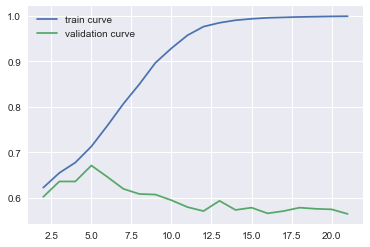

best depth of the decision tree: 5
best validation accuracy: 0.67125


In [10]:
plt.plot(depths, train_scores, label='train curve')
plt.plot(depths, valid_scores, label='validation curve')
plt.legend()
plt.show()
print('best depth of the decision tree:',best_depth)
print('best validation accuracy:',best_valid_score)

The decision tree overfeats beyond a depth of 5 stages.

## 03.02 Random forests

In [18]:
# Estimator size range
estimators_sizes=np.arange(50,500,50) #setting estimators for grid searching

train_scores=[]
valid_scores=[]

for estimator_n in estimators_sizes:
    # Creating the random forest object using the best maximum depth from the Decision tree model
    rf=RandomForestClassifier(n_estimators=estimator_n,max_depth=best_depth, random_state=0,n_jobs=-1)
    
    #on train
    rf.fit(X_train,y_train)
    train_scores.append(rf.score(X_train,y_train))
    
    #on test
    valid_scores.append(rf.score(X_valid,y_valid))
    
    
idx=np.argmax(valid_scores)
best_size=estimators_sizes[idx]
best_valid_score=valid_scores[idx]

In [19]:
# Collecting results in a DataFrame
scores_df=pd.DataFrame({'n estimators':estimators_sizes,'validation accuracy':valid_scores,'train accuracy':train_scores})

In [20]:
print(scores_df)
print('Best estimators size:',best_size)
print('Best validation accuracy:{:.3f}'.format(best_valid_score))

   n estimators  train accuracy  validation accuracy
0            50        0.823125              0.71125
1           100        0.831875              0.70125
2           150        0.833750              0.70250
3           200        0.831562              0.70250
4           250        0.835625              0.71125
5           300        0.838125              0.71250
6           350        0.834063              0.70625
7           400        0.835313              0.71000
8           450        0.835625              0.70625
Best estimators size: 300
Best validation accuracy:0.713


## 03.03 Evaluating the models

In [21]:
# Reducing the Overfeat features of the test set with the PCA using 175 components tuned on the train set
X_Of_te_r=scaler.fit_transform(X_overfeat_te) #standardising features
X_Of_te_175r=pca175.fit_transform(X_Of_te_r)
pve = pca175.explained_variance_ratio_ # Variance explained by components
print('Shape of preprocessed Overfeat matrix:',X_Of_te_175r.shape)
print('Percentage of variance explained: {:.2f}'.format(np.max(np.cumsum(pve))))

Shape of preprocessed Overfeat matrix: (1000, 175)
Percentage of variance explained: 0.92


In [22]:
# Evaluating the Decision tree
dt=DecisionTreeClassifier(criterion='gini',max_depth=best_depth,random_state=0)
dt.fit(X_train,y_train)
train_accuracy_dt=dt.score(X_train,y_train)
test_accuracy_dt=dt.score(X_valid,y_valid)

In [23]:
# Evaluating the Random forest
rf=RandomForestClassifier(n_estimators=best_size,max_depth=best_depth, random_state=0, n_jobs=-1)
rf.fit(X_train,y_train)
train_accuracy_rf=rf.score(X_train,y_train)
test_accuracy_rf=rf.score(X_Of_te_175r,y_te)

In [24]:
# Printing accuracy values
print('Decision tree accuracy (test set): {:.2f}'.format(test_accuracy_dt))
print('Decision tree accuracy (train set): {:.2f}'.format(train_accuracy_dt))
print()
print('Random forest accuracy (test set): {:.2f}'.format(test_accuracy_rf))
print('Random forest accuracy (train set): {:.2f}'.format(train_accuracy_rf))

Decision tree accuracy (test set): 0.67
Decision tree accuracy (train set): 0.71

Random forest accuracy (test set): 0.34
Random forest accuracy (train set): 0.84


The random forest model appearently overfits the train set.